In [1]:
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
from stats import graph_stats
import backboning as bb
from collections import Counter

In [2]:
hashtags_to_remove = set([
    'hashtag', 'fyp', 'foryou', 'foryoupage', 'fypシ', 'viral', 'love',
    'trending', 'tiktok', 'funny', 'fypage', 'capcut', 'duet', 'news',
    'foryourpage', 'fy', 'fypシ゚viral', 'follow', 'viralvideo', 'like',
    'trend', 'stitch', 'video', 'lol', 'instagram', 'asmr', 'explorepage',
    'instagood', 'viraltiktok', 'youtube', 'share', 'new', '2023', 'reels',
    'followme', 'vlog', 'satisfying', 'viralvideos', 'wow', 'funnyvideos',
    'repost', 'relatable', 'followforfollowback', 'breakingnews', 'storytime',
    'tiktokfamous', 'greenscreenvideo', 'for', 'foru', 'tiktoktrend', 'goviral',
    'bhfyp', 'viralpost', 'f', 'tiktoker', 'fypp', 'fyppppppppppppppppppppppp',
    'tiktokviral', '4upage', 'forupage', '4you', 'xyzabc', 'xyzcba', '4u', 'xyzbca', 'trendy', 'oh', 'ohno', 'relatable', 'bhfyp', 'trending', '2023', 'follow', 'explorepage', 'like', 'viral', 'tiktok', 'fybシ', 'usa_tiktok',
    'foruyou', 'trends', 'fybpage', 'trendiing', 'forupage', 'fyb', 'foryourpage', 'foryoupage', 'viralvideo', 'fyou', 'foryou', '4u', '4you', 'pageforyou', 'fyp', 'series', 'fdseite', 'fypage',
    'fyoupage', 'fds', '4upage', 'tiktokfanpage', '4youpage', 'fürdich', 'fyoupagetiktok', 'viralllllll', 'dancetrends', 'dancetrend', 'duet', 'share'
])

In [3]:
def backbone_pipepline(filepath, threshold, is_directed, hashtags_to_remove = hashtags_to_remove):
    with open(filepath, "rb") as f:
        G = pickle.load(f)

    G.remove_nodes_from(hashtags_to_remove)

    edge_data = [
    {'src': u, 'trg': v, 'nij': d['weight']}
    for u, v, d in G.edges(data=True)]

    df = pd.DataFrame(edge_data)

    if is_directed:
        disparity_applied = bb.disparity_filter(df, undirected = False)
    else:
        disparity_applied = bb.disparity_filter(df, undirected = True)

    thresh_applied = bb.thresholding(disparity_applied, threshold=threshold).drop(columns=["score"])

    if is_directed:
        backbone = nx.from_pandas_edgelist(
        thresh_applied,
        source="src",
        target="trg",
        edge_attr="nij",
        create_using=nx.DiGraph())
    else:
        backbone = nx.from_pandas_edgelist(
        thresh_applied,
        source="src",
        target="trg",
        edge_attr="nij",
        create_using=nx.Graph())
    
    return backbone

In [5]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values."""
    x = np.array(x)
    if np.amin(x) < 0:
        raise ValueError("Gini coefficient is not defined for negative values.")
    if np.amin(x) == 0:
        # Avoid division by zero
        x = x + 1e-10
    
    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    
    return (2 * np.sum(index * x_sorted) / (n * np.sum(x_sorted))) - (n + 1) / n


In [11]:
def load_and_filter_graph(filepath, is_directed, hashtags_to_remove):
    with open(filepath, "rb") as f:
        G = pickle.load(f)
    
    G.remove_nodes_from(hashtags_to_remove)

    edge_data = [
        {'src': u, 'trg': v, 'nij': d['weight']}
        for u, v, d in G.edges(data=True)
    ]

    df = pd.DataFrame(edge_data)

    disparity_applied = bb.disparity_filter(df, undirected=not is_directed)

    return disparity_applied


def build_backbone_from_disparity(disparity_df, threshold, is_directed):
    thresh_applied = bb.thresholding(disparity_df, threshold=threshold).drop(columns=["score"])

    graph_type = nx.DiGraph() if is_directed else nx.Graph()
    backbone = nx.from_pandas_edgelist(
        thresh_applied,
        source="src",
        target="trg",
        edge_attr="nij",
        create_using=graph_type
    )

    return backbone


def choose_threshold_by_gcc_size(filepath, thresholds, is_directed=False, hashtags_to_remove=hashtags_to_remove, plot=True):
    disparity_applied = load_and_filter_graph(filepath, is_directed, hashtags_to_remove)

    gcc_sizes = []
    edge_counts = []
    original_size = None

    for t in thresholds:
        backbone = build_backbone_from_disparity(disparity_applied, threshold=t, is_directed=is_directed)

        components = (
            nx.weakly_connected_components(backbone) if is_directed else nx.connected_components(backbone)
        )
        largest_cc_size = len(max(components, key=len))
        num_edges = backbone.number_of_edges()

        gcc_sizes.append((t, largest_cc_size))
        edge_counts.append((t, num_edges))

        if original_size is None:
            original_size = backbone.number_of_nodes()


    gcc_sizes = np.array(gcc_sizes)
    edge_counts = np.array(edge_counts) 

    if plot:
        fig, ax1 = plt.subplots(figsize=(10, 5))

        ax1.set_xlabel("Threshold", fontsize=14)
        ax1.set_ylabel("GCC Size", color="blue", fontsize=14)
        ax1.tick_params(axis='y', labelcolor="blue", labelsize=12)
        ax1.tick_params(axis='x', labelsize=12)

        l1, = ax1.plot(gcc_sizes[:, 0], gcc_sizes[:, 1], marker='o', color="blue", label="GCC Size")

        ax2 = ax1.twinx()
        ax2.set_ylabel("Number of Edges", color="red", fontsize=14)
        ax2.tick_params(axis='y', labelcolor="red", labelsize=12)

        l2, = ax2.plot(edge_counts[:, 0], edge_counts[:, 1], marker='s', linestyle='--', color="red", label="Edge Count")

        # Combine legends from both axes
        lines = [l1, l2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc="upper right", fontsize=12)

        plt.title("GCC Size & Edge Count vs Threshold", fontsize=16)
        plt.grid(True)
        fig.tight_layout()
        plt.show()


    return max(gcc_sizes, key=lambda x: x[1])  # Return the threshold with the largest GCC size


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def choose_threshold_by_gcc_size(filepath, thresholds, is_directed=False, hashtags_to_remove=None, plot=True):
    # Load and filter the graph
    disparity_applied = load_and_filter_graph(filepath, is_directed, hashtags_to_remove)

    # Initialize lists to store metrics
    gcc_sizes = []
    edge_counts = []
    num_components_list = []
    original_size = None

    for t in thresholds:
        # Build backbone at current threshold
        backbone = build_backbone_from_disparity(disparity_applied, threshold=t, is_directed=is_directed)

        # Identify connected components
        if is_directed:
            components = list(nx.weakly_connected_components(backbone))
        else:
            components = list(nx.connected_components(backbone))

        # Compute metrics
        largest_cc_size = len(max(components, key=len)) if components else 0
        num_edges = backbone.number_of_edges()
        num_components = len(components)

        # Store metrics
        gcc_sizes.append((t, largest_cc_size))
        edge_counts.append((t, num_edges))
        num_components_list.append((t, num_components))

        if original_size is None:
            original_size = backbone.number_of_nodes()

    # Convert to NumPy arrays for easier indexing
    gcc_sizes = np.array(gcc_sizes)
    edge_counts = np.array(edge_counts)
    num_components_arr = np.array(num_components_list)

    # Plotting section
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # 1x3 grid

        # Plot 1: GCC Size vs Threshold
        ax1.set_xlabel("Threshold", fontsize=14)
        ax1.set_ylabel("GCC Size", color="blue", fontsize=14)
        ax1.tick_params(axis='y', labelcolor="blue", labelsize=12)
        ax1.tick_params(axis='x', labelsize=12)
        ax1.plot(gcc_sizes[:, 0], gcc_sizes[:, 1], marker='o', color="blue", label="GCC Size")
        ax1.legend(loc="best", fontsize=12)
        ax1.set_title("GCC Size vs Threshold", fontsize=16)

        # Plot 2: Edge Count vs Threshold
        ax2.set_xlabel("Threshold", fontsize=14)
        ax2.set_ylabel("Edge Count", color="red", fontsize=14)
        ax2.tick_params(axis='y', labelcolor="red", labelsize=12)
        ax2.tick_params(axis='x', labelsize=12)
        ax2.plot(edge_counts[:, 0], edge_counts[:, 1], marker='s', linestyle='--', color="red", label="Edge Count")
        ax2.legend(loc="best", fontsize=12)
        ax2.set_title("Edge Count vs Threshold", fontsize=16)

        # Plot 3: Number of Components vs Threshold
        ax3.set_xlabel("Threshold", fontsize=14)
        ax3.set_ylabel("Number of Components", color="green", fontsize=14)
        ax3.tick_params(axis='y', labelcolor="green", labelsize=12)
        ax3.tick_params(axis='x', labelsize=12)
        ax3.plot(num_components_arr[:, 0], num_components_arr[:, 1], marker='^', linestyle=':', color="green", label="Component Count")
        ax3.legend(loc="best", fontsize=12)
        ax3.set_title("Number of Components vs Threshold", fontsize=16)

        # Final layout adjustment
        plt.tight_layout()
        plt.show()

    # Return the threshold corresponding to the maximum GCC size
    return max(gcc_sizes, key=lambda x: x[1])


# Hashtag coocurence

In [14]:
hashtag_path = '../../shared-folder-gald/data/unipartite_og.pkl'

Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:199: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:200: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:201: FutureWarning: In a future version of pandas 

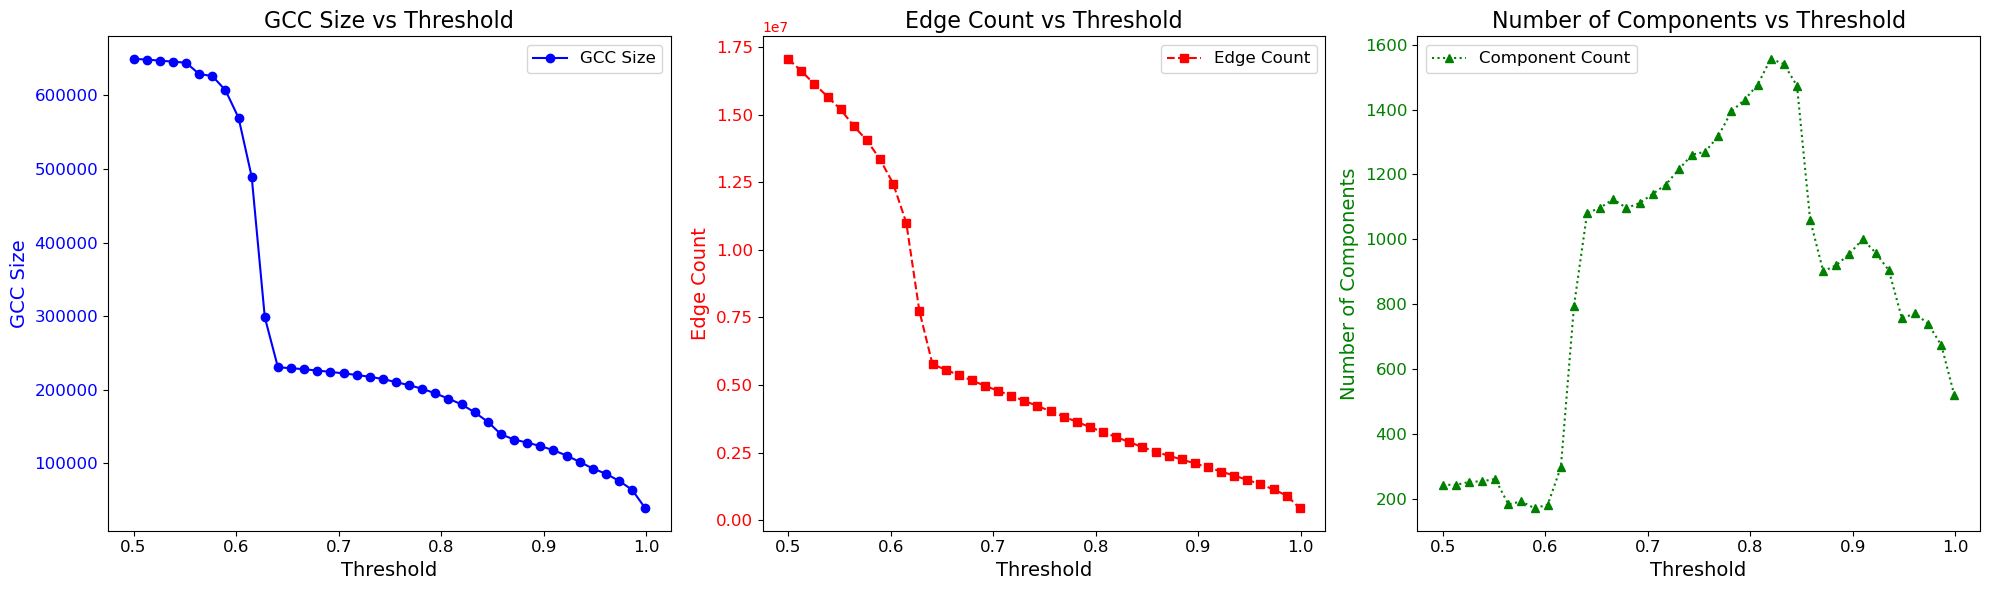

In [16]:
thresholds_to_test = np.linspace(0.5, 0.999, 40)

gcc_size = choose_threshold_by_gcc_size(
    filepath=hashtag_path,
    thresholds=thresholds_to_test,
    is_directed=False,
    hashtags_to_remove=hashtags_to_remove
)



Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:199: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:200: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:201: FutureWarning: In a future version of pandas 

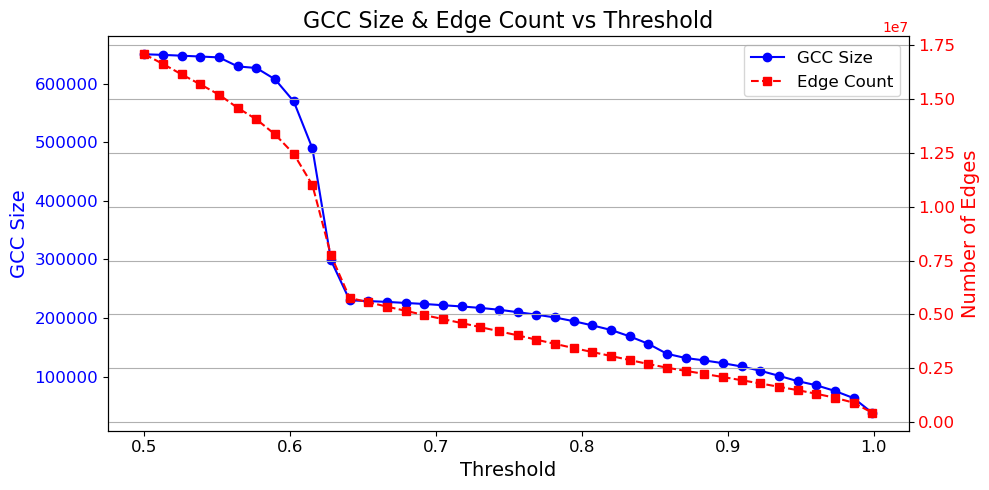

In [15]:
thresholds_to_test = np.linspace(0.5, 0.999, 40)

gcc_size = choose_threshold_by_gcc_size(
    filepath=hashtag_path,
    thresholds=thresholds_to_test,
    is_directed=False,
    hashtags_to_remove=hashtags_to_remove
)



Since we cannot afford huge graphs, we will use threshold = 0.999

In [29]:
hashtag_backbone = backbone_pipepline(hashtag_path, threshold=0.999, is_directed=False)

Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:199: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:200: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:201: FutureWarning: In a future version of pandas 

In [30]:
HC_stats = graph_stats(hashtag_backbone)

Calculating best minimal value for power law fit


Assuming nested distributions


In [31]:
for key, val in HC_stats.items():
    print(key,'-', val)

num_nodes - 39905
num_edges - 435990
density - 0.0005475991646961855
mean_degree - 21.851397068036587
std_degree - 64.35798163702205
global_clustering_coeff - 0.20309534642693478
degree_assortativity - 0.017341503555157775
GCC_size - 38558
power_law_alpha - 2.6810422480191924
power_law_xmin - 114.0
ks_test_statistic - 0.030015460618940448
best_powerlaw_comparison - power law vs truncated_power_law: R = -14.425, p = 0.000


In [32]:
with open('../ready_networks/cooc_filtered.pkl', 'wb') as f:
    pickle.dump(hashtag_backbone, f)

In [17]:
with open('../ready_networks/cooc_filtered.pkl', "rb") as f:
        hc_backbone = pickle.load(f)

In [18]:
print(f'Avg clustering {nx.average_clustering(hc_backbone)}')

Avg clustering 0.5439670613165997


# Follow

In [7]:
follow_path = '../../shared-folder-gald/data/follow_graph.pkl'

Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()


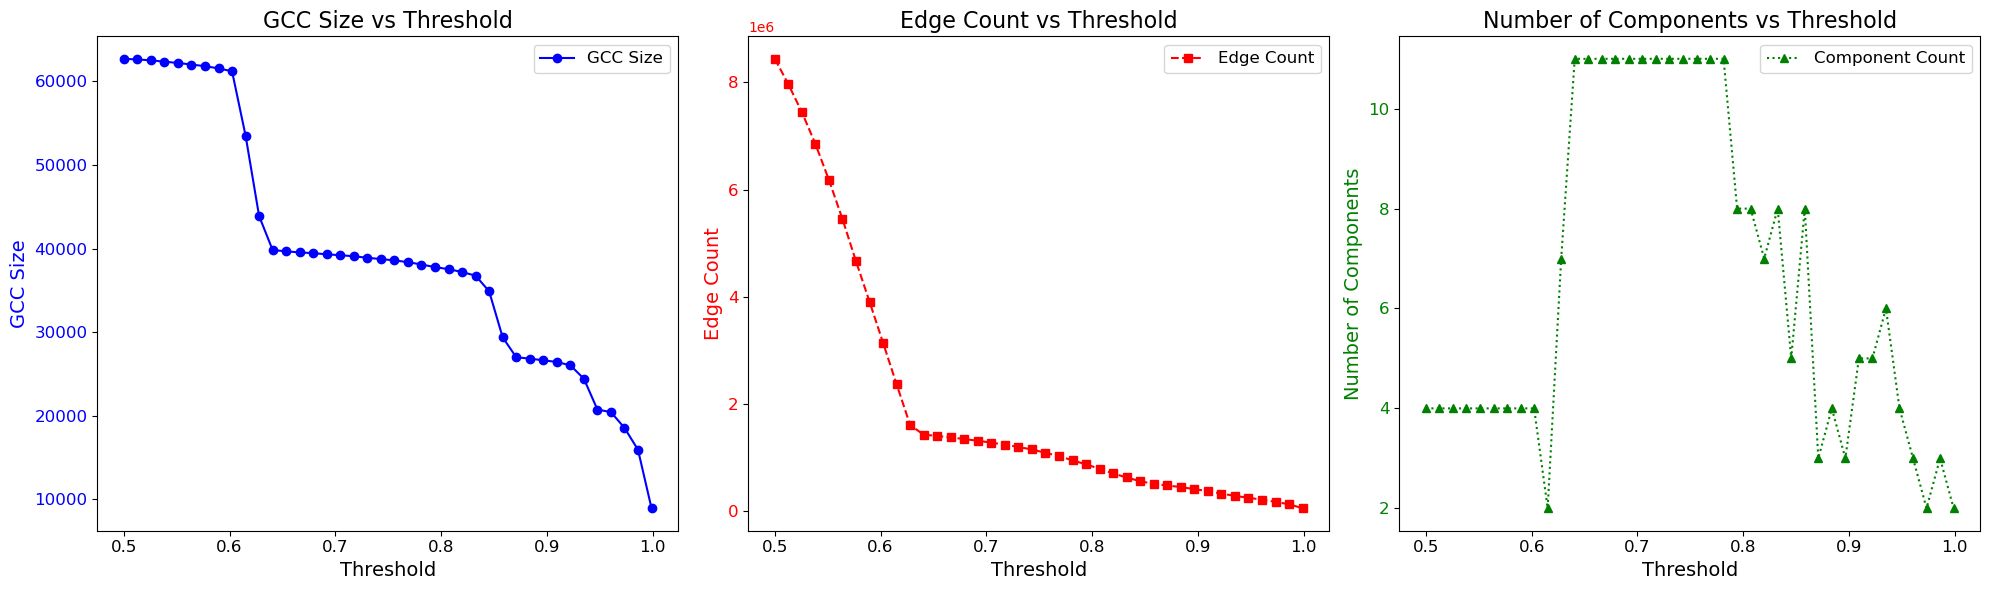

In [8]:
thresholds_to_test = np.linspace(0.5, 0.999, 40)

best_threshold, gcc_size = choose_threshold_by_gcc_size(
    filepath=follow_path,
    thresholds=thresholds_to_test,
    is_directed=True,
    hashtags_to_remove=hashtags_to_remove
)


Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()


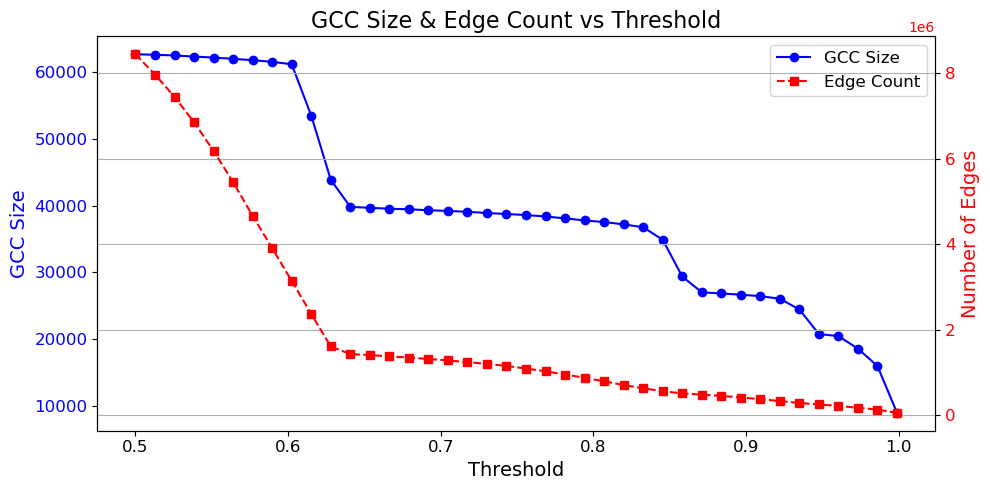

In [12]:
thresholds_to_test = np.linspace(0.5, 0.999, 40)

best_threshold, gcc_size = choose_threshold_by_gcc_size(
    filepath=follow_path,
    thresholds=thresholds_to_test,
    is_directed=True,
    hashtags_to_remove=hashtags_to_remove
)


Since we want to downsize the network and we can see that the GCC size remains stable around 0.9-0.92 threshold, we are going to choose 0.92 as threshold to downsize as much as possible.

In [16]:
follow_backbone = backbone_pipepline(follow_path, threshold=0.92, is_directed=True)

Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()


In [17]:
follow_stats = graph_stats(follow_backbone)

Calculating best minimal value for power law fit


/Users/renatasapeta/anaconda3/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


In [18]:
for key, val in follow_stats.items():
    print(key,'-', val)

num_nodes - 26153
num_edges - 334979
density - 0.0004897688505192232
mean_degree - 25.61686995755745
std_degree - 160.62665597799972
global_clustering_coeff - 0.2883105854272922
degree_assortativity - -0.28749195924457355
power_law_alpha - 2.0506972354050497
power_law_xmin - 11.0
ks_test_statistic - 0.013620791460423387
best_powerlaw_comparison - power law vs truncated_power_law: R = -1.701, p = 0.065


In [19]:
with open('../ready_networks/follow_filtered.pkl', 'wb') as f:
    pickle.dump(follow_backbone, f)

In [9]:
with open('../ready_networks/follow_filtered.pkl', "rb") as f:
        follow_backbone = pickle.load(f)

In [10]:
print(f'Avg clustering {nx.average_clustering(follow_backbone)}')

Avg clustering 0.7084682267385343


# Duet/Stitch filtered hashtags

In [61]:
with open('../ready_networks/ds_network.pkl', 'rb') as f:
    ds = pickle.load(f)

ds.remove_nodes_from(hashtags_to_remove)

with open('../ready_networks/ds_network.pkl', 'wb') as f:
    pickle.dump(ds, f)

# Likes filtered hashtags

In [62]:
with open('../ready_networks/likes_network.pkl', 'rb') as f:
    likes = pickle.load(f)

likes.remove_nodes_from(hashtags_to_remove)

with open('../ready_networks/likes_network.pkl', 'wb') as f:
    pickle.dump(likes, f)

# Inspecting the difference in GCC and edge count graphs

Hashtag co-occurence

In [6]:
hashtag_path = '../../shared-folder-gald/data/unipartite_og.pkl'
hashtag_backbone = backbone_pipepline(hashtag_path, threshold=0.9, is_directed=False)

Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:199: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:200: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:201: FutureWarning: In a future version of pandas 

In [62]:
# Load the original hashtag graph
hashtag_path = '../../shared-folder-gald/data/unipartite_og.pkl'
with open(hashtag_path, 'rb') as f:
    hashtag_graph = pickle.load(f)

# Convert to undirected for clustering analysis (if it's not already undirected)
hashtag_undirected = hashtag_graph.to_undirected()

# Compute the average clustering coefficient for the full graph
avg_clustering = nx.average_clustering(hashtag_undirected)

print(f"Average clustering coefficient of the original hashtag graph: {avg_clustering:.4f}")

Average clustering coefficient of the original hashtag graph: 0.8240


In [8]:
# For undirected co-occurrence graph
degrees = dict(hashtag_backbone.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50]

for node in top_nodes:
    ego = nx.ego_graph(hashtag_backbone, node, radius=1)
    clustering = nx.average_clustering(ego)
    print(f"{node}: degree={degrees[node]}, clustering={clustering}")


art: degree=7467, clustering=0.6292018647682196
happy: degree=5475, clustering=0.6368057193226817
fun: degree=5366, clustering=0.6183604499558621
life: degree=5339, clustering=0.6353738641394072
travel: degree=5216, clustering=0.6547816244833268
food: degree=5001, clustering=0.6711753538283292
comedy: degree=4563, clustering=0.6564497892944869
music: degree=4495, clustering=0.6812850738728079
usa: degree=4416, clustering=0.6643505620589266
nature: degree=4281, clustering=0.6716770700283521
foodie: degree=4213, clustering=0.6805113144891376
politics: degree=4115, clustering=0.6798078133457066
family: degree=4010, clustering=0.6451466628666772
cute: degree=3970, clustering=0.6640979696723438
meme: degree=3958, clustering=0.6694523176206765
motivation: degree=3632, clustering=0.6632493161075964
beautiful: degree=3567, clustering=0.6621345479580238
vegan: degree=3482, clustering=0.6840680671863866
fashion: degree=3391, clustering=0.6976096738910632
photography: degree=3385, clustering=0.69

Follows

In [61]:
follow_path = '../../shared-folder-gald/data/follow_graph.pkl'
with open(follow_path, 'rb') as f:
    follow_graph = pickle.load(f)

# Convert to undirected for clustering analysis
follow_undirected = follow_graph.to_undirected()

# Compute average clustering coefficient for the full graph
avg_clustering = nx.average_clustering(follow_undirected)

print(f"Average clustering coefficient of the original follow graph: {avg_clustering:.4f}")

Average clustering coefficient of the original follow graph: 0.3969


In [59]:
follow_path = '../../shared-folder-gald/data/follow_graph.pkl'
follow_backbone = backbone_pipepline(follow_path, threshold=0.8, is_directed=True)

Calculating DF score...
/Users/renatasapeta/Desktop/bachelor/Bachelor/filtering/backboning.py:184: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()


In [ ]:
follow_undirected = follow_backbone.to_undirected()
degrees = dict(follow_undirected.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50]

for node in top_nodes:
    ego = nx.ego_graph(follow_undirected, node, radius=1)
    clustering = nx.average_clustering(ego)
    print(f"{node}: degree={degrees[node]}, clustering={clustering}")


politics: degree=10065, clustering=0.7680416172760945
climatechange: degree=9054, clustering=0.7819497785651262
sustainability: degree=8125, clustering=0.8075419440984849
climatecrisis: degree=6922, clustering=0.7933302953514065
sustainablefashion: degree=6921, clustering=0.8005544010879465
zerowaste: degree=6699, clustering=0.8136771604408585
sustainableliving: degree=6693, clustering=0.8039851743455902
greenscreen: degree=6682, clustering=0.7232180586067996
ecofriendly: degree=6370, clustering=0.8252974310963639
sustainable: degree=5900, clustering=0.8002129264874354
learnontiktok: degree=5817, clustering=0.7312133225438681
climateaction: degree=5703, clustering=0.8129425502849915
biden: degree=5028, clustering=0.7963019668861756
ecotok: degree=4470, clustering=0.8227509802242652
animals: degree=4463, clustering=0.7420928157161629
slowfashion: degree=4369, clustering=0.8049282357481119
ocean: degree=4330, clustering=0.735403524833568
frenchbulldogforsale: degree=4290, clustering=0.73

### Degree distribution

Hashtag co-occurence

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

# Get degree of each node
degrees = dict(hashtag_backbone.degree())
degrees = [d for n, d in hashtag_backbone.degree()]
degree_count = Counter(degrees)

# Separate the keys and values for plotting
deg, cnt = zip(*sorted(degree_count.items()))

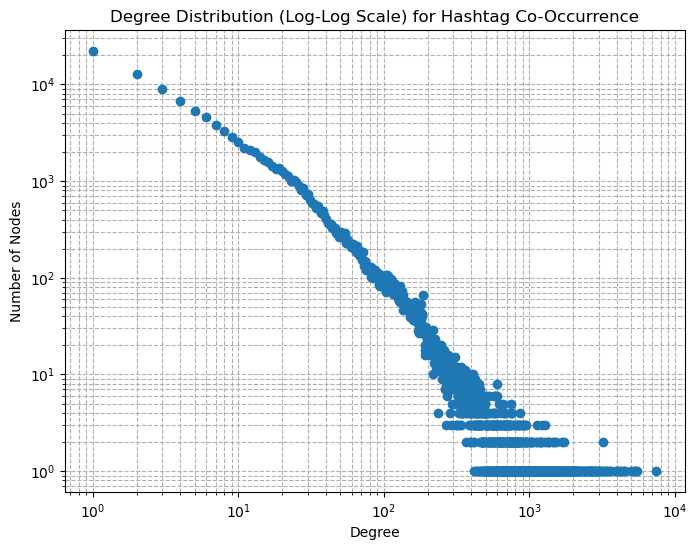

In [16]:
plt.figure(figsize=(8, 6))
plt.loglog(deg, cnt, marker='o', linestyle='none')
plt.title("Degree Distribution (Log-Log Scale) for Hashtag Co-Occurrence")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True, which="both", ls="--")
plt.show()


In [11]:
degrees = np.array(degrees)
print('mean:', np.mean(degrees),
      'median:', np.median(degrees),
      'max:', np.max(degrees),
      'std:', np.std(degrees),
      'min:', np.min(degrees),
      'num_nodes:', len(degrees))

mean: 33.17315490346245 median: 7.0 max: 7467 std: 120.7735194776581 min: 1 num_nodes: 124045


In [21]:
gini_deg = gini_coefficient(degrees)
print("Gini coefficient of degree distribution:", gini_deg)

Gini coefficient of degree distribution: 0.7810354385100711


Follows

In [22]:
# Get degree of each node
follow_undirected = follow_backbone.to_undirected()
degrees = [d for n, d in follow_undirected.degree()]
degree_count = Counter(degrees)

# Separate the keys and values for plotting
deg, cnt = zip(*sorted(degree_count.items()))

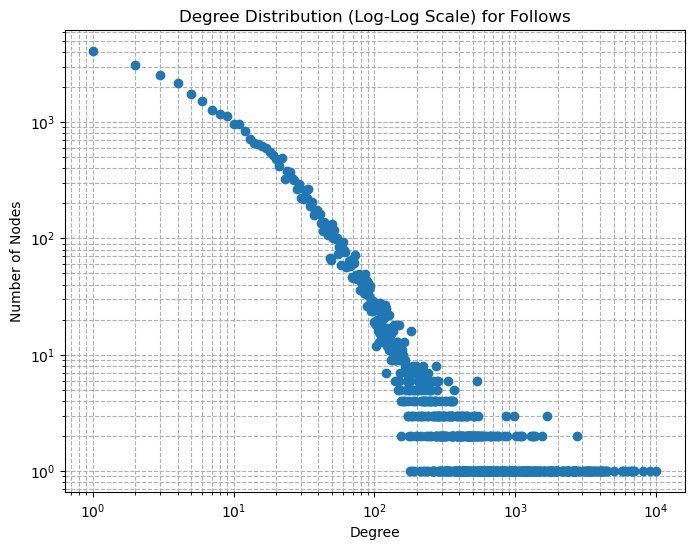

In [18]:
plt.figure(figsize=(8, 6))
plt.loglog(deg, cnt, marker='o', linestyle='none')
plt.title("Degree Distribution (Log-Log Scale) for Follows")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True, which="both", ls="--")
plt.show()


In [11]:
degrees = np.array(degrees)
print('mean:', np.mean(degrees),
      'median:', np.median(degrees),
      'max:', np.max(degrees),
      'std:', np.std(degrees),
      'min:', np.min(degrees),
      'num_nodes:', len(degrees))

mean: 40.0855291117722 median: 10.0 max: 10065 std: 215.04956463965897 min: 1 num_nodes: 37648


In [23]:
gini_deg = gini_coefficient(degrees)
print("Gini coefficient of degree distribution:", gini_deg)

Gini coefficient of degree distribution: 0.7896439452579194


<Figure size 800x600 with 0 Axes>

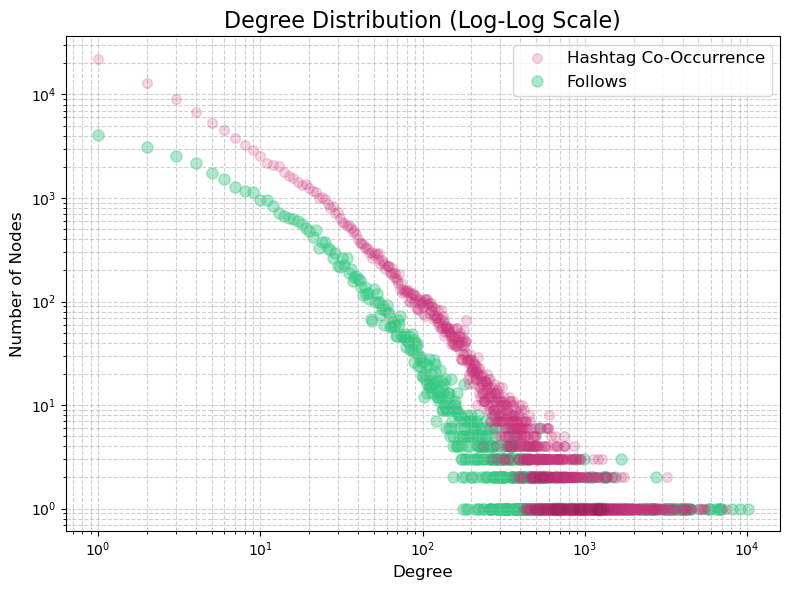

In [41]:
import matplotlib.pyplot as plt
from collections import Counter

plt.figure(figsize=(8, 6))

# --- Hashtag backbone ---
hashtag_degrees = [d for n, d in hashtag_backbone.degree()]
hashtag_degree_count = Counter(hashtag_degrees)
deg_h, cnt_h = zip(*sorted(hashtag_degree_count.items()))
hashtag_points = set(zip(deg_h, cnt_h))

plt.figure(figsize=(8, 6))

# --- Hashtag backbone ---
plt.loglog(
    deg_h, cnt_h,
    marker='o',
    linestyle='none',
    label="Hashtag Co-Occurrence",
    color="#ca357d",
    markersize=7,
    alpha=0.2,
    zorder=2  # Ensures they're drawn on top of follows
)

# --- Follow backbone (undirected) ---
plt.loglog(
    deg_f, cnt_f,
    marker='o',
    linestyle='none',
    label="Follows",
    color="#35CA82",
    markersize=8,
    alpha=0.4,
    zorder=1
)

# --- Overlapping points ---
if overlap_points:
    plt.loglog(
        deg_o, cnt_o,
        marker='o',
        linestyle='none',
        color='black',
        alpha=0.01,
        markersize=10,
        zorder=3
    )


# --- Plot styling ---
plt.title("Degree Distribution (Log-Log Scale)", fontsize=16)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
